## Step 1: Installations

In [1]:
!pip install /kaggle/input/wheelhouse-cibmtr/torchsurv-0.1.4-py3-none-any.whl
!pip install lifelines -q --no-index --find-links=/kaggle/input/cibmtr2024-import/lifelines
!pip install scikit-learn -q --no-index --find-links=/kaggle/input/wheelhouse-cibmtr/scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing /kaggle/input/wheelhouse-cibmtr/torchsurv-0.1.4-py3-none-any.whl
  Preparing metadata (setup.py) ... done


## Step 2: Imports

In [2]:
import os
import gc
import torch
import copy
import warnings
import lifelines
import pandas as pd
import numpy as np
from tqdm import tqdm
from metric import score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, PredefinedSplit
warnings.filterwarnings("ignore")

from torchsurv.loss.cox import neg_partial_log_likelihood
from torchsurv.loss.weibull import neg_log_likelihood, log_hazard, survival_function
from torchsurv.metrics.brier_score import BrierScore
from torchsurv.metrics.cindex import ConcordanceIndex
from torchsurv.metrics.auc import Auc
from torchsurv.stats.kaplan_meier import KaplanMeierEstimator

print(f"torch version: {torch.__version__}")
print(f"lifelines version: {lifelines.__version__}")

torch version: 2.5.1+cu121
lifelines version: 0.30.0


# 2. Configuration

In [3]:
class config:
    root = "/kaggle/input/equity-post-HCT-survival-predictions"
    train_path = "/kaggle/input/cibmtr-2024-dataset/random_folding.xlsx"
    test_path = os.path.join(root, "test.csv")
    sub_path = os.path.join(root, "sample_submission.csv")
    seed = 42
    n_folds = 5
    epochs = 20
    batch_size = 2048
    learning_rate = 1e-3

# 3. Loading & Preprocessing Data

In [4]:
def add_features(df):
    """
    Create some new features to help the model focus on specific patterns.
    """
    df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
    df['year_hct'] -= 2000
    
    return df

train_df = pd.read_excel(config.train_path)
eval_df = train_df[["ID", "efs", "efs_time", "race_group"]].copy()
test_df = pd.read_csv(config.test_path)

train_df = add_features(train_df)
test_df = add_features(test_df)

target_cols = ["efs", "efs_time"]
drop_cols = ["ID"]

cat_cols = [col for col in train_df.select_dtypes(include=["object"]).columns if col not in target_cols + drop_cols]
num_cols = [col for col in train_df.columns if col not in cat_cols + target_cols + drop_cols]

print(f"cat_cols: {len(cat_cols)}")
print(f"num_cols: {len(num_cols)}")

# Categorical Features
for col in cat_cols:
    train_df[col].fillna("Unknown", inplace=True)
    test_df[col].fillna("Unknown", inplace=True)

    labels = train_df[col].unique()
    for i in labels:
        train_df[f"{col}_{i}"] = train_df[col].apply(lambda x: 1 if x == i else 0)
        test_df[f"{col}_{i}"] = test_df[col].apply(lambda x: 1 if x == i else 0)

    if col != "race_group":
        train_df.drop(columns=[col], axis=1, inplace=True)
    test_df.drop(columns=[col], axis=1, inplace=True)

# Numerical Features
for col in num_cols:
    if col != "fold":
        imputer = SimpleImputer(strategy='mean')
        train_df[col] = imputer.fit_transform(train_df[col].values.reshape(-1, 1))
        test_df[col] = imputer.transform(test_df[col].values.reshape(-1, 1))

train_df = train_df.drop(columns=drop_cols, axis=1)
test_df = test_df.drop(columns=drop_cols, axis=1)

print(f"train: {train_df.shape}")
print(f"test: {test_df.shape}")

train_df.head()

cat_cols: 35
num_cols: 24
train: (28800, 218)
test: (3, 214)


,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,...,melphalan_dose_MEL,melphalan_dose_Unknown,cardiac_No,cardiac_Yes,cardiac_Not done,cardiac_Unknown,pulm_moderate_No,pulm_moderate_Yes,pulm_moderate_Not done,pulm_moderate_Unknown
0,1.764516,6.876801,6.0,6.0,8.61723,2.0,6.0,2.0,2.0,2.0,...,0,0,1,0,0,0,1,0,0,0
1,2.000000,8.000000,6.0,6.0,10.00000,2.0,6.0,2.0,2.0,2.0,...,0,0,1,0,0,0,0,1,0,0
2,2.000000,8.000000,6.0,6.0,10.00000,2.0,6.0,2.0,2.0,2.0,...,0,0,1,0,0,0,1,0,0,0
3,2.000000,8.000000,6.0,6.0,10.00000,2.0,6.0,2.0,2.0,2.0,...,0,0,1,0,0,0,1,0,0,0
4,2.000000,8.000000,6.0,6.0,10.00000,2.0,5.0,2.0,2.0,2.0,...,1,0,1,0,0,0,1,0,0,0


In [5]:
if "fold" in list(train_df.columns):
    print("Yessss")

Yessss


# 4. Creating Cross-Validation Folds

In [6]:
print(train_df["fold"].value_counts().sort_index())

train_df = train_df.drop(columns=["race_group"], axis=1)
test_df["efs"] = np.nan
test_df["efs_time"] = np.nan

scaler = StandardScaler()
inputs = [col for col in train_df.columns if col not in target_cols and col !="fold"]
train_df[inputs] = scaler.fit_transform(train_df[inputs])
test_df[inputs] = scaler.transform(test_df[inputs])

fold
0    2880
1    2880
2    2880
3    2880
4    2880
5    2880
6    2880
7    2880
8    2880
9    2880
Name: count, dtype: int64


In [7]:
if "fold" in list(train_df.columns):
    print("Yessss")

Yessss


# 5. Modeling

In [8]:
class Custom_dataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        event = torch.tensor(sample["efs"]).bool()
        time = torch.tensor(sample["efs_time"]).float()
        x = torch.tensor(sample.drop(["efs", "efs_time"]).values).float()
        return x, (event, time)

def load_cox_model(num_features: int):
    cox_model = torch.nn.Sequential(
        torch.nn.BatchNorm1d(num_features),
        torch.nn.Linear(num_features, 32),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.2, inplace=False),
        torch.nn.Linear(32, 64),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.2, inplace=False),
        torch.nn.Linear(64, 1),
    )
    return cox_model

def plot_losses(train_losses: list, val_losses: list, title: str = "Cox") -> None:
    train_losses = torch.stack(train_losses) / train_losses[0]
    val_losses = torch.stack(val_losses) / val_losses[0]
    plt.plot(train_losses, label="training")
    plt.plot(val_losses, label="validation")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Normalized loss")
    plt.title(title)
    plt.yscale("log")
    plt.show()

def train_model(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    dataloader_train: torch.utils.data.DataLoader,
    dataloader_val: torch.utils.data.DataLoader,
    epochs: int,
    plot: bool = True
):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        epoch_loss = torch.tensor(0.0)
        for i, batch in enumerate(dataloader_train):
            x, (event, time) = batch
            optimizer.zero_grad()
            log_hz = cox_model(x)
            loss = neg_partial_log_likelihood(log_hz, event, time, reduction="mean")
            loss.backward()
            optimizer.step()
            epoch_loss += loss.detach()
        epoch_loss /= i + 1

        with torch.no_grad():
            x, (event, time) = next(iter(dataloader_val))
            val_loss = neg_partial_log_likelihood(cox_model(x), event, time, reduction="mean")
            val_losses.append(val_loss)
            
        print(f"Epoch: {epoch}, Train Loss: {epoch_loss:.5f} Val Loss: {val_loss:.5f}")
        train_losses.append(epoch_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)

    if plot:
        plot_losses(train_losses, val_losses, "Cox")

    return model

def infer(model: torch.nn.Module, dataloader_test: torch.utils.data.DataLoader):
    model.eval()
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_test))
        log_hz = model(x)
    return log_hz, event, time

def validate_model(data: pd.DataFrame, preds):
    y_true = data[['ID', 'efs', 'efs_time', 'race_group']].copy()
    y_pred = data[['ID']].copy()
    y_pred['prediction'] = preds
    c_index_score = score(y_true.copy(), y_pred.copy(), 'ID')
    return c_index_score

========================================| Fold 1 |========================================
Epoch: 0, Train Loss: 7.72551 Val Loss: 8.23819
Epoch: 1, Train Loss: 7.65575 Val Loss: 8.18669
Epoch: 2, Train Loss: 7.59678 Val Loss: 8.14506
Epoch: 3, Train Loss: 7.60518 Val Loss: 8.12913
Epoch: 4, Train Loss: 7.58195 Val Loss: 8.10976
Epoch: 5, Train Loss: 7.56316 Val Loss: 8.10457
Epoch: 6, Train Loss: 7.54084 Val Loss: 8.10749
Epoch: 7, Train Loss: 7.54108 Val Loss: 8.10128
Epoch: 8, Train Loss: 7.52679 Val Loss: 8.10493
Epoch: 9, Train Loss: 7.50246 Val Loss: 8.11017
Epoch: 10, Train Loss: 7.49737 Val Loss: 8.10555
Epoch: 11, Train Loss: 7.49341 Val Loss: 8.10906
Epoch: 12, Train Loss: 7.52679 Val Loss: 8.09450
Epoch: 13, Train Loss: 7.50763 Val Loss: 8.10846
Epoch: 14, Train Loss: 7.49939 Val Loss: 8.12256
Epoch: 15, Train Loss: 7.49996 Val Loss: 8.11008
Epoch: 16, Train Loss: 7.47843 Val Loss: 8.11770
Epoch: 17, Train Loss: 7.49988 Val Loss: 8.12560
Epoch: 18, Train Loss: 7.46807 Val Lo

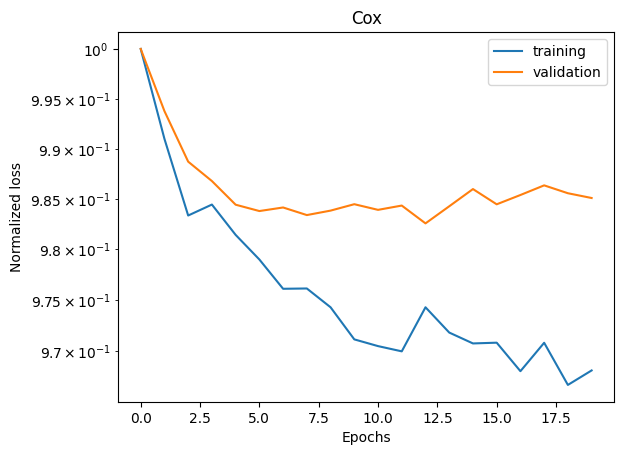

Model saved to cox_model_fold_0.pt
C-Index: 0.66985
Stratified C-Index: 0.65076
Confidence Interval: tensor([0.6422, 0.6975])

========================================| Fold 2 |========================================
Epoch: 0, Train Loss: 7.74688 Val Loss: 8.26073
Epoch: 1, Train Loss: 7.68302 Val Loss: 8.18580
Epoch: 2, Train Loss: 7.63341 Val Loss: 8.14728
Epoch: 3, Train Loss: 7.56236 Val Loss: 8.11326
Epoch: 4, Train Loss: 7.56175 Val Loss: 8.11655
Epoch: 5, Train Loss: 7.53707 Val Loss: 8.10327
Epoch: 6, Train Loss: 7.53835 Val Loss: 8.10817
Epoch: 7, Train Loss: 7.54724 Val Loss: 8.10227
Epoch: 8, Train Loss: 7.53702 Val Loss: 8.10478
Epoch: 9, Train Loss: 7.50925 Val Loss: 8.10021
Epoch: 10, Train Loss: 7.53945 Val Loss: 8.09301
Epoch: 11, Train Loss: 7.50827 Val Loss: 8.10122
Epoch: 12, Train Loss: 7.49155 Val Loss: 8.09525
Epoch: 13, Train Loss: 7.52225 Val Loss: 8.10704
Epoch: 14, Train Loss: 7.52829 Val Loss: 8.09951
Epoch: 15, Train Loss: 7.49112 Val Loss: 8.10681
Epoch: 1

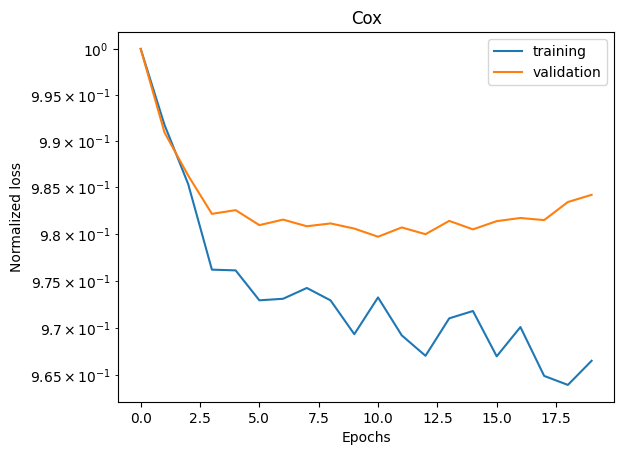

Model saved to cox_model_fold_1.pt
C-Index: 0.66997
Stratified C-Index: 0.65403
Confidence Interval: tensor([0.6424, 0.6975])

========================================| Fold 3 |========================================
Epoch: 0, Train Loss: 7.72210 Val Loss: 8.23288
Epoch: 1, Train Loss: 7.64568 Val Loss: 8.16172
Epoch: 2, Train Loss: 7.61022 Val Loss: 8.13056
Epoch: 3, Train Loss: 7.58101 Val Loss: 8.10621
Epoch: 4, Train Loss: 7.58187 Val Loss: 8.11336
Epoch: 5, Train Loss: 7.56078 Val Loss: 8.10527
Epoch: 6, Train Loss: 7.53981 Val Loss: 8.10587
Epoch: 7, Train Loss: 7.53489 Val Loss: 8.10281
Epoch: 8, Train Loss: 7.52889 Val Loss: 8.10646
Epoch: 9, Train Loss: 7.52829 Val Loss: 8.11058
Epoch: 10, Train Loss: 7.52790 Val Loss: 8.10219
Epoch: 11, Train Loss: 7.48363 Val Loss: 8.09626
Epoch: 12, Train Loss: 7.50333 Val Loss: 8.11401
Epoch: 13, Train Loss: 7.49929 Val Loss: 8.11929
Epoch: 14, Train Loss: 7.49300 Val Loss: 8.10987
Epoch: 15, Train Loss: 7.51517 Val Loss: 8.10155
Epoch: 1

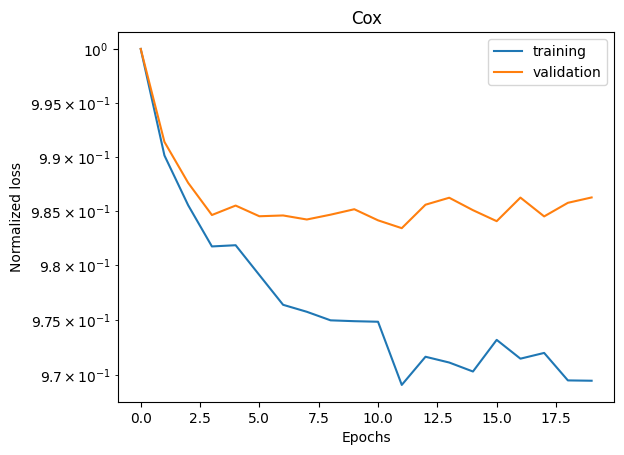

Model saved to cox_model_fold_2.pt
C-Index: 0.67101
Stratified C-Index: 0.65250
Confidence Interval: tensor([0.6433, 0.6987])

========================================| Fold 4 |========================================
Epoch: 0, Train Loss: 7.72463 Val Loss: 8.23976
Epoch: 1, Train Loss: 7.64728 Val Loss: 8.17241
Epoch: 2, Train Loss: 7.62098 Val Loss: 8.14742
Epoch: 3, Train Loss: 7.54467 Val Loss: 8.11304
Epoch: 4, Train Loss: 7.55389 Val Loss: 8.11948
Epoch: 5, Train Loss: 7.51790 Val Loss: 8.10836
Epoch: 6, Train Loss: 7.52890 Val Loss: 8.10414
Epoch: 7, Train Loss: 7.51039 Val Loss: 8.10478
Epoch: 8, Train Loss: 7.52185 Val Loss: 8.10308
Epoch: 9, Train Loss: 7.52205 Val Loss: 8.10956
Epoch: 10, Train Loss: 7.52044 Val Loss: 8.09768
Epoch: 11, Train Loss: 7.56071 Val Loss: 8.10493
Epoch: 12, Train Loss: 7.47326 Val Loss: 8.10142
Epoch: 13, Train Loss: 7.51337 Val Loss: 8.11186
Epoch: 14, Train Loss: 7.52097 Val Loss: 8.11049
Epoch: 15, Train Loss: 7.47287 Val Loss: 8.11504
Epoch: 1

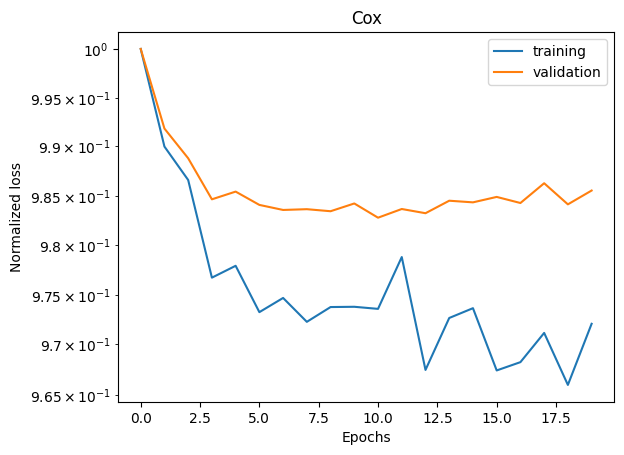

Model saved to cox_model_fold_3.pt
C-Index: 0.66941
Stratified C-Index: 0.65204
Confidence Interval: tensor([0.6417, 0.6971])

========================================| Fold 5 |========================================
Epoch: 0, Train Loss: 7.75256 Val Loss: 8.22450
Epoch: 1, Train Loss: 7.63223 Val Loss: 8.17127
Epoch: 2, Train Loss: 7.60019 Val Loss: 8.14382
Epoch: 3, Train Loss: 7.58189 Val Loss: 8.11231
Epoch: 4, Train Loss: 7.56836 Val Loss: 8.10604
Epoch: 5, Train Loss: 7.54158 Val Loss: 8.10878
Epoch: 6, Train Loss: 7.54592 Val Loss: 8.11205
Epoch: 7, Train Loss: 7.53999 Val Loss: 8.10150
Epoch: 8, Train Loss: 7.53797 Val Loss: 8.10680
Epoch: 9, Train Loss: 7.53756 Val Loss: 8.09834
Epoch: 10, Train Loss: 7.52989 Val Loss: 8.10117
Epoch: 11, Train Loss: 7.52380 Val Loss: 8.10025
Epoch: 12, Train Loss: 7.51244 Val Loss: 8.10609
Epoch: 13, Train Loss: 7.51202 Val Loss: 8.10314
Epoch: 14, Train Loss: 7.51364 Val Loss: 8.10849
Epoch: 15, Train Loss: 7.50840 Val Loss: 8.11719
Epoch: 1

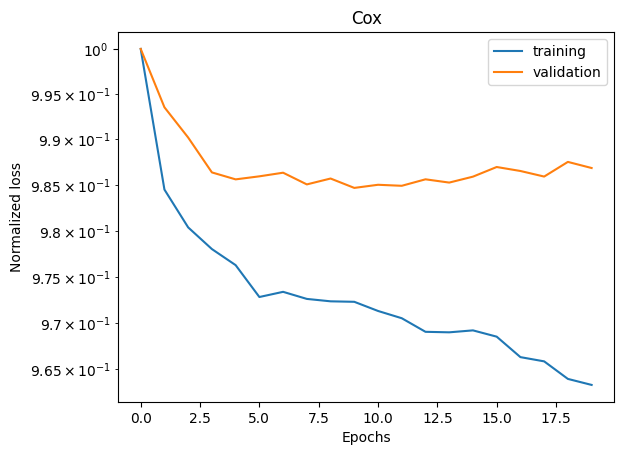

Model saved to cox_model_fold_4.pt
C-Index: 0.66931
Stratified C-Index: 0.65408
Confidence Interval: tensor([0.6418, 0.6968])

========================================| Fold 6 |========================================
Epoch: 0, Train Loss: 7.72136 Val Loss: 8.23218
Epoch: 1, Train Loss: 7.63327 Val Loss: 8.17575
Epoch: 2, Train Loss: 7.60785 Val Loss: 8.15299
Epoch: 3, Train Loss: 7.60224 Val Loss: 8.12628
Epoch: 4, Train Loss: 7.56591 Val Loss: 8.11194
Epoch: 5, Train Loss: 7.54168 Val Loss: 8.11588
Epoch: 6, Train Loss: 7.55993 Val Loss: 8.10012
Epoch: 7, Train Loss: 7.53688 Val Loss: 8.10052
Epoch: 8, Train Loss: 7.52440 Val Loss: 8.10085
Epoch: 9, Train Loss: 7.51084 Val Loss: 8.10656
Epoch: 10, Train Loss: 7.51825 Val Loss: 8.11273
Epoch: 11, Train Loss: 7.53519 Val Loss: 8.10853
Epoch: 12, Train Loss: 7.49879 Val Loss: 8.10175
Epoch: 13, Train Loss: 7.53784 Val Loss: 8.10753
Epoch: 14, Train Loss: 7.50992 Val Loss: 8.11161
Epoch: 15, Train Loss: 7.50289 Val Loss: 8.11376
Epoch: 1

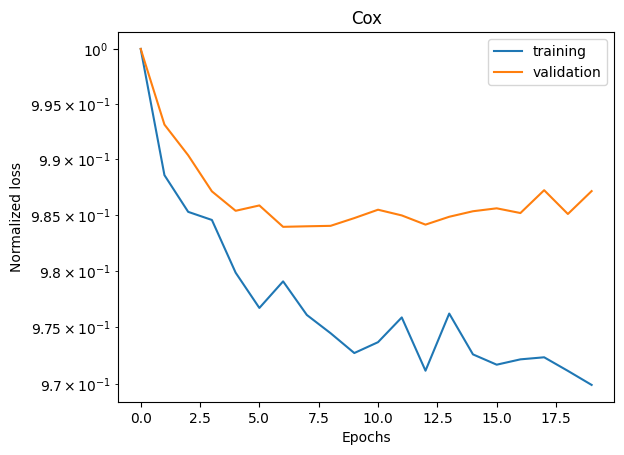

Model saved to cox_model_fold_5.pt
C-Index: 0.66669
Stratified C-Index: 0.65171
Confidence Interval: tensor([0.6392, 0.6942])

========================================| Fold 7 |========================================
Epoch: 0, Train Loss: 7.73339 Val Loss: 8.23228
Epoch: 1, Train Loss: 7.65373 Val Loss: 8.16758
Epoch: 2, Train Loss: 7.62312 Val Loss: 8.13907
Epoch: 3, Train Loss: 7.59133 Val Loss: 8.12776
Epoch: 4, Train Loss: 7.57107 Val Loss: 8.10738
Epoch: 5, Train Loss: 7.55091 Val Loss: 8.10862
Epoch: 6, Train Loss: 7.53679 Val Loss: 8.10456
Epoch: 7, Train Loss: 7.54189 Val Loss: 8.10378
Epoch: 8, Train Loss: 7.55193 Val Loss: 8.10165
Epoch: 9, Train Loss: 7.53626 Val Loss: 8.10292
Epoch: 10, Train Loss: 7.51518 Val Loss: 8.09658
Epoch: 11, Train Loss: 7.51511 Val Loss: 8.10403
Epoch: 12, Train Loss: 7.53089 Val Loss: 8.10365
Epoch: 13, Train Loss: 7.49370 Val Loss: 8.10776
Epoch: 14, Train Loss: 7.49894 Val Loss: 8.11102
Epoch: 15, Train Loss: 7.51745 Val Loss: 8.11474
Epoch: 1

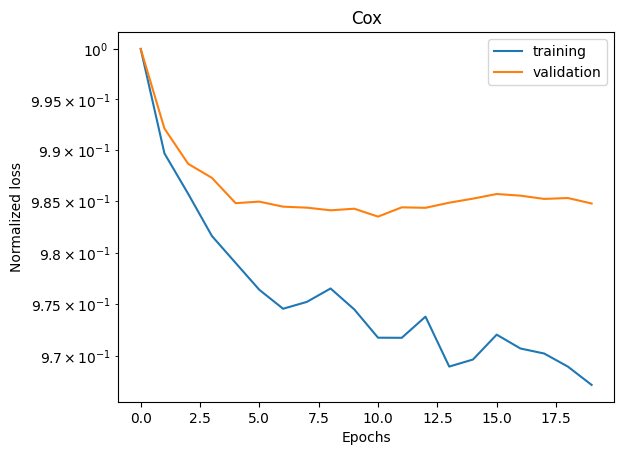

Model saved to cox_model_fold_6.pt
C-Index: 0.66978
Stratified C-Index: 0.65204
Confidence Interval: tensor([0.6423, 0.6972])

========================================| Fold 8 |========================================
Epoch: 0, Train Loss: 7.71782 Val Loss: 8.22015
Epoch: 1, Train Loss: 7.66177 Val Loss: 8.16362
Epoch: 2, Train Loss: 7.60304 Val Loss: 8.12643
Epoch: 3, Train Loss: 7.57237 Val Loss: 8.11167
Epoch: 4, Train Loss: 7.55052 Val Loss: 8.10471
Epoch: 5, Train Loss: 7.54904 Val Loss: 8.11079
Epoch: 6, Train Loss: 7.54425 Val Loss: 8.10613
Epoch: 7, Train Loss: 7.53175 Val Loss: 8.10281
Epoch: 8, Train Loss: 7.53440 Val Loss: 8.10446
Epoch: 9, Train Loss: 7.51381 Val Loss: 8.09356
Epoch: 10, Train Loss: 7.53194 Val Loss: 8.09879
Epoch: 11, Train Loss: 7.51515 Val Loss: 8.10554
Epoch: 12, Train Loss: 7.49758 Val Loss: 8.11180
Epoch: 13, Train Loss: 7.49140 Val Loss: 8.10469
Epoch: 14, Train Loss: 7.51385 Val Loss: 8.10110
Epoch: 15, Train Loss: 7.49800 Val Loss: 8.09926
Epoch: 1

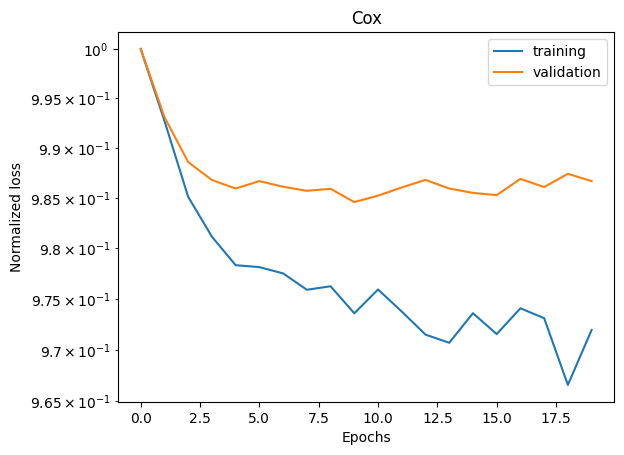

Model saved to cox_model_fold_7.pt
C-Index: 0.67071
Stratified C-Index: 0.65209
Confidence Interval: tensor([0.6432, 0.6982])

========================================| Fold 9 |========================================
Epoch: 0, Train Loss: 7.71578 Val Loss: 8.22848
Epoch: 1, Train Loss: 7.66049 Val Loss: 8.17072
Epoch: 2, Train Loss: 7.62180 Val Loss: 8.14366
Epoch: 3, Train Loss: 7.57138 Val Loss: 8.12588
Epoch: 4, Train Loss: 7.53978 Val Loss: 8.11457
Epoch: 5, Train Loss: 7.55994 Val Loss: 8.10370
Epoch: 6, Train Loss: 7.52628 Val Loss: 8.10330
Epoch: 7, Train Loss: 7.52424 Val Loss: 8.10598
Epoch: 8, Train Loss: 7.51487 Val Loss: 8.09933
Epoch: 9, Train Loss: 7.50004 Val Loss: 8.10024
Epoch: 10, Train Loss: 7.55129 Val Loss: 8.09570
Epoch: 11, Train Loss: 7.50469 Val Loss: 8.09285
Epoch: 12, Train Loss: 7.49360 Val Loss: 8.10078
Epoch: 13, Train Loss: 7.52462 Val Loss: 8.10404
Epoch: 14, Train Loss: 7.52045 Val Loss: 8.10881
Epoch: 15, Train Loss: 7.50974 Val Loss: 8.09289
Epoch: 1

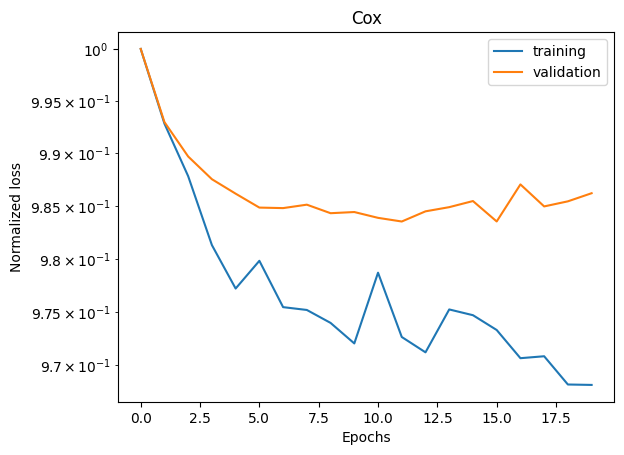

Model saved to cox_model_fold_8.pt
C-Index: 0.67217
Stratified C-Index: 0.65465
Confidence Interval: tensor([0.6447, 0.6997])

=======================================| Fold 10 |========================================
Epoch: 0, Train Loss: 7.73895 Val Loss: 8.22840
Epoch: 1, Train Loss: 7.63171 Val Loss: 8.15988
Epoch: 2, Train Loss: 7.60684 Val Loss: 8.13571
Epoch: 3, Train Loss: 7.56449 Val Loss: 8.11500
Epoch: 4, Train Loss: 7.55560 Val Loss: 8.11038
Epoch: 5, Train Loss: 7.54089 Val Loss: 8.10078
Epoch: 6, Train Loss: 7.55072 Val Loss: 8.11108
Epoch: 7, Train Loss: 7.53130 Val Loss: 8.10671
Epoch: 8, Train Loss: 7.53685 Val Loss: 8.09185
Epoch: 9, Train Loss: 7.52357 Val Loss: 8.09147
Epoch: 10, Train Loss: 7.52360 Val Loss: 8.10533
Epoch: 11, Train Loss: 7.50839 Val Loss: 8.10549
Epoch: 12, Train Loss: 7.53580 Val Loss: 8.09677
Epoch: 13, Train Loss: 7.50030 Val Loss: 8.10246
Epoch: 14, Train Loss: 7.47693 Val Loss: 8.10294
Epoch: 15, Train Loss: 7.49104 Val Loss: 8.11044
Epoch: 1

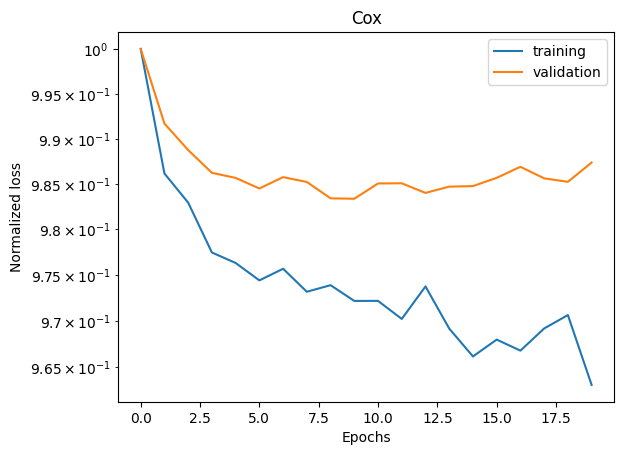

Model saved to cox_model_fold_9.pt
C-Index: 0.67137
Stratified C-Index: 0.65430
Confidence Interval: tensor([0.6437, 0.6990])


CV: 0.65282


In [9]:
dataloader_test = DataLoader(
    Custom_dataset(test_df), batch_size=len(test_df), shuffle=False
)

folds = 10
models = list()
oof_ts = np.zeros(len(train_df))

fold_scores = list()
for idx in range(folds):

    model_save_path = f"/kaggle/working/fold_{idx}/"
    
    print(f"| Fold {idx+1} |".center(90, "="))
    train_index = train_df[train_df["fold"]!=0].index
    val_index = train_df[train_df["fold"]==0].index

    train = train_df.loc[train_index]
    train.drop(["fold"], axis=1, inplace=True)
    val = train_df.loc[val_index]
    val.drop(["fold"], axis=1, inplace=True)
    
    dataloader_train = DataLoader(
        Custom_dataset(train), batch_size=config.batch_size, shuffle=True
    )
    dataloader_val = DataLoader(
        Custom_dataset(val), batch_size=len(train_df.loc[val_index]), shuffle=False
    )

    num_features = next(iter(dataloader_train))[0].size(1)
    cox_model = load_cox_model(num_features)
    optimizer = torch.optim.Adam(cox_model.parameters(), lr=config.learning_rate)
    
    cox_model = train_model(cox_model, optimizer, dataloader_train, dataloader_val, config.epochs)
    log_hz, event, time = infer(cox_model, dataloader_val)
    models.append(cox_model)

    cox_cindex = ConcordanceIndex()
    fold_score = validate_model(eval_df.loc[val_index], log_hz.view(-1).numpy())
    fold_scores.append(fold_score)

    oof_ts[val_index] = log_hz.view(-1).numpy()

    model_save_path = f"cox_model_fold_{idx}.pt"
    torch.save(cox_model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

    print(f"C-Index: {cox_cindex(log_hz, event, time):.5f}")
    print(f"Stratified C-Index: {fold_score:.5f}")
    print(f"Confidence Interval: {cox_cindex.confidence_interval()}\n")

print(f"\nCV: {np.mean(fold_scores):.5f}")

# 6. Saving Submission

In [10]:
sub = pd.read_csv(config.sub_path)
test_preds = np.zeros(len(test_df))

for model in tqdm(models):
    test_preds += infer(model, dataloader_test)[0].view(-1).numpy() / len(models)

sub["prediction"] = test_preds
sub.to_csv("submission.csv", index=False)
sub.head()

100%|██████████| 10/10 [00:00<00:00, 212.35it/s]


,ID,prediction
0,28800,-1.833778
1,28801,-0.171331
2,28802,-2.474316


In [11]:
train_df["predictions"] = oof_ts
train_df.to_parquet("ts_exp_01_oof.parquet")